* https://medium.com/@lessw/new-state-of-the-art-ai-optimizer-rectified-adam-radam-5d854730807b
* https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d
* https://medium.com/@lessw/meet-mish-new-state-of-the-art-ai-activation-function-the-successor-to-relu-846a6d93471f


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.vision.data import ImageDataBunch, get_transforms
from fastai.metrics import error_rate, accuracy
from pathlib import Path
import os

In [2]:
from mish import Mish


In [3]:
act_fn = Mish()
act_fn

Mish activation loaded


Mish()

In [4]:
from ranger import Ranger
optar = partial(Ranger)

In [5]:
path = Path(os.getcwd())/"data"/"ants_and_bees"
tfms = get_transforms()
data = ImageDataBunch.from_folder(path, train="train", valid="val", ds_tfms=tfms, size=224, bs=10) # from_folder labels data based on the folder name
#same as pytorch : only applies transform to training loader. Training loader is set with shuffle true while val loader is not

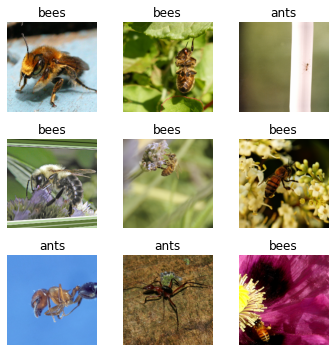

In [6]:
data.show_batch(rows=3, figsize=(5,5), ds_type=DatasetType.Train)

In [7]:
data.classes, data.c

(['ants', 'bees'], 2)

In [8]:
len(data.train_ds), len(data.valid_ds), 

(245, 153)

In [9]:
# torch.cuda.empty_cache()

In [18]:
def convert_relu_to_mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            convert_relu_to_mish(child)

In [19]:
learn = cnn_learner(data, models.vgg16_bn, metrics=accuracy, opt_func=optar)
convert_relu_to_mish(learn.model)
learn.summary()

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded
Mish activation loaded


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 224, 224]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
Mish                 [64, 224, 224]       0          False     
______________________________________________________________________
Conv2d               [64, 224, 224]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
Mish                 [64, 224, 224]       0          False     
______________________________________________________________________
MaxPool2d            [64, 112, 112]       0          False     
___________________________________________________

In [12]:
torch.cuda.empty_cache()

In [13]:
learn.lr_find()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


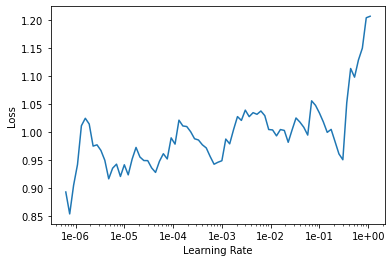

In [14]:
learn.recorder.plot() 

In [20]:
lr = 1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.7)
# it is not the same to run fit one cycle more than once : https://forums.fast.ai/t/running-fit-one-cycle-more-than-once/48037

epoch,train_loss,valid_loss,accuracy,time
0,1.425874,1.303823,0.333333,00:45
1,1.332499,1.000349,0.483660,00:45
2,1.372330,0.978149,0.483660,00:44
3,1.276029,0.790850,0.555556,00:44
4,1.154444,0.654860,0.640523,00:44
5,1.089855,0.573056,0.699346,00:44
6,1.029408,0.497614,0.771242,00:45
7,0.937674,0.470669,0.771242,00:45
8,0.867351,0.457876,0.764706,00:45
9,0.823908,0.451868,0.784314,00:45


In [21]:
learn.save("testmish_mod")

In [22]:
learn.load("testmish_mod")

set state called


Learner(data=ImageDataBunch;

Train: LabelList (245 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ants,ants,ants,ants,ants
Path: c:\Users\Gabriel\Documents\workprojects\pytorch\data\ants_and_bees;

Valid: LabelList (153 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ants,ants,ants,ants,ants
Path: c:\Users\Gabriel\Documents\workprojects\pytorch\data\ants_and_bees;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Mish()
      (6): Ma

In [23]:
len(learn.recorder.lrs) # 120 iterations total

240

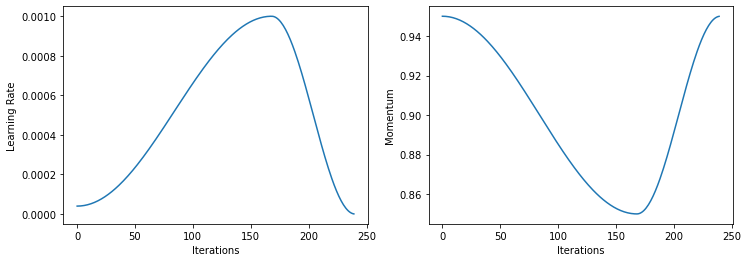

In [24]:
learn.recorder.plot_lr(show_moms=True) # to do the same in pytorch, i would have to modify lr and momentum for each parameters at each iteration

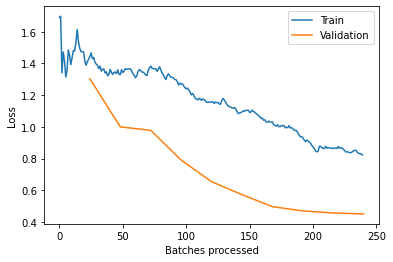

In [25]:
learn.recorder.plot_losses()

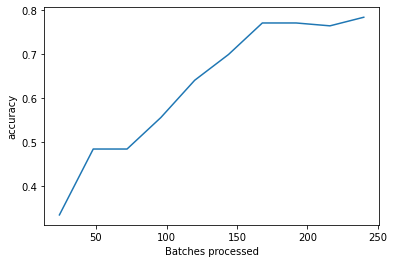

In [26]:
learn.recorder.plot_metrics()

moins bons résultats mais c'est normal car le réseau a été initialement entrainé avec relu donc le transfer learning est pas ouf